# 📚 Experience Sharing
- TIMM for UWB classification
- Gradient Accumulation
- Weighted ensemble
- Pseudo-labeling

**Contact**: senmeeja #9894 🤙

**Special credit** 🙏:
- Parinzee #2980 🐧

**P.S.** This code was written by N'Parin EXP, and added some comments/notes by Senmee. I apologize if there are any wrong infomation 🥺🙏.

📝 Note: Interesting content
- TIMM https://github.com/huggingface/pytorch-image-models
- Getting Started with PyTorch Image Models (timm): A Practitioner’s Guide
https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055#0afa
- Lookahead Optimizer: k steps forward, 1 step back
https://www.youtube.com/watch?v=TxGxiDK0Ccc

# Installing Requirements

In [ ]:
!pip install torch transformers datasets evaluate pillow==9.2.0
!pip install git+https://github.com/rwightman/pytorch-image-models.git

# Restart Kernel
import os
os.kill(os.getpid(), 9)   # 9: SIGKILL
                          # 15: SIGTERM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-pn41ahhy
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-pn41ahhy
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit 4b8cfa6c0a355a9b3cb2a77298b240213fb3b921
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.1 MB/s eta 0:00:00
  Created wheel for timm: filename=timm-0.8.15.dev0-py3-none-any.whl size=1994477 sha256=8ae76f13b0dd1957c3c417b625fe3ec7c625c02892b845e27a06a1ba5974e975
  Stored in directory: /tmp/pip-ephem-wheel-cache-mhme6p8k/wheels/eb/1e/79/4dfc1bba276172378ab3e51ceed8e1e59ff8fba24e453244bd
Successfully built timm


# Load Data
The preprocessed data can be looked in [SHARING_SignalPreparation.ipynb](https://colab.research.google.com/drive/1pymdRXkO-Q8SLAWTq0qKADFYS_Nm_4wz?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# copy preprocessed signal data to local notebook
!cp -r drive/MyDrive/signal ./

# Intialize Training

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

# Pytorch Image model (TIMM) library: a library for state-of-the-art image classification
import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image

import evaluate

import numpy as np
import pandas as pd
from scipy import stats

from tqdm.notebook import tqdm

import glob

from sklearn.model_selection import KFold

from copy import copy

import shutil

## Data Processing

In [ ]:
# Collect all train image path
train_files = glob.glob("signal/signal_train/**/*.png")
test_files = glob.glob("signal/signal_test/*.png")

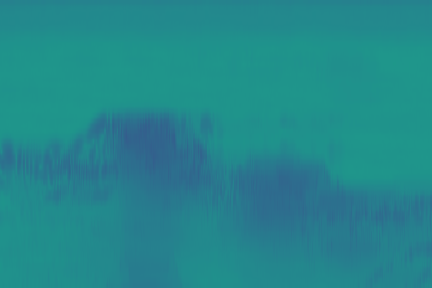

In [ ]:
# Visualize image
example = Image.open(train_files[0]).convert("RGB")
display(example)

In [ ]:
# Transform image data based on ImageNet's mean and std
transforms = {
    "train": T.Compose([
        T.Resize((384, 384), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
    "test": T.Compose([
        T.Resize((384, 384), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ])
}

📝 Note: Resizing Filters
- **Sampling down**: Lanczos or Spline filtering.
- **Sampling up**: Lanczos or Bicubic filtering
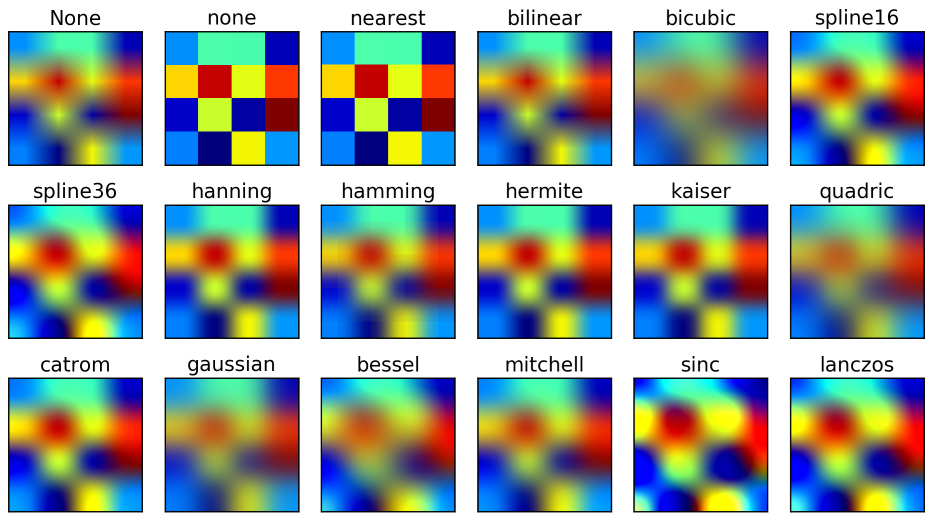

In [ ]:
# Convert a tensor or an ndarray to PIL Image
toImage = T.ToPILImage()

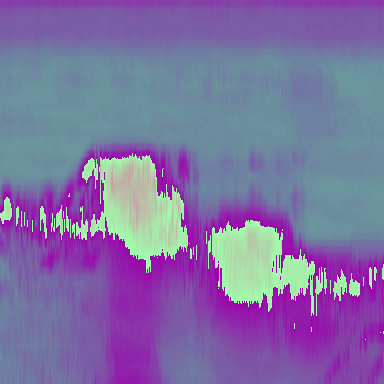

In [ ]:
# Display an example of transform images
toImage(transforms["train"](example))

In [ ]:
# Assign dataset from train signal
dataset = ImageDataset("signal/signal_train", transform=transforms["train"])

# Model Training

In [ ]:
# List all available models
timm.list_models("")

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_2_rw_384',
 'coatnet_rmlp_3_rw_224',
 'coatnet_rmlp_nano_rw

In [ ]:
# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Select model (List of available is shown above)
model_name = "hf_hub:timm/maxvit_base_tf_224.in1k"    # : EDIT HERE : Change model name

In [ ]:
num_epochs = 25
criterion = nn.CrossEntropyLoss()

# Cross Validation Configuration
k_splits = 5
metric = evaluate.load("f1")

In [ ]:
# Cross validation
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

📝 Note: Cross validation
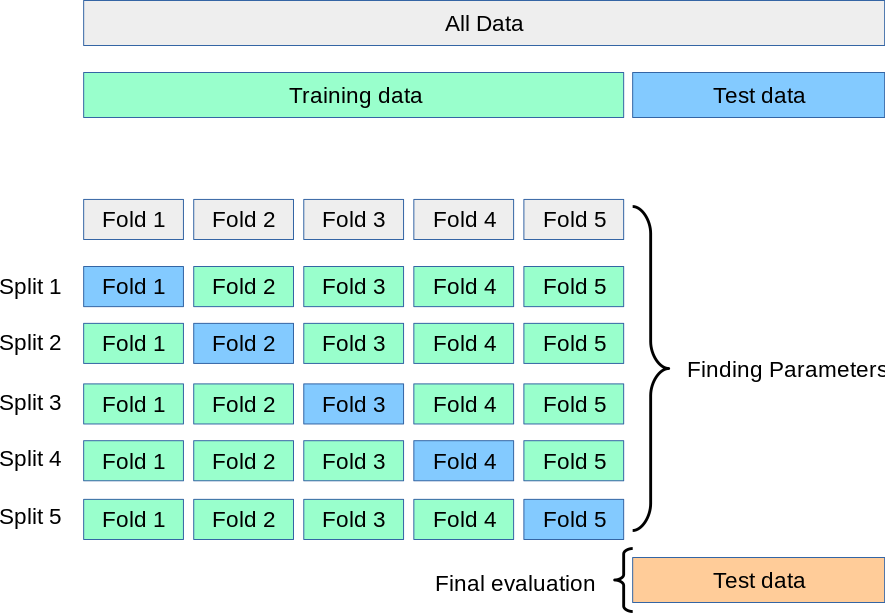

In [ ]:
# Gradient Accumulation Settings
# Set to 1 for no accumulation
train_batch_size = 8
eval_batch_size = 16
num_accumulate = 4

📝 Note: Gradient Accumulation


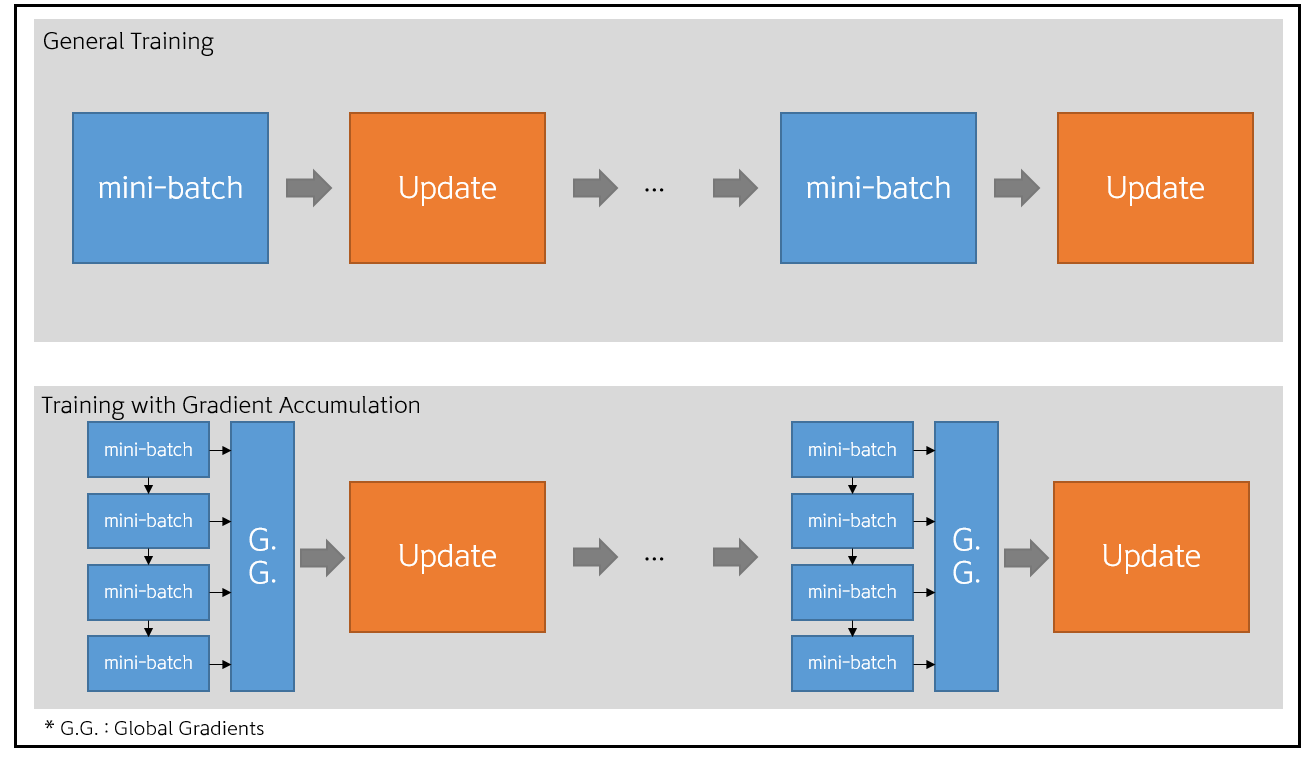

In [ ]:
all_eval_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1} of 5")

    # Load Model
    model = timm.create_model(model_name, pretrained=True, num_classes=7).to(device)

    # Load Optimizer and Scheduler
    optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=1e-3)
    optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=6)                           # update the slow weight every k steps
                                                                                          # update the optimizer by combine slow weight and fast weight * alpha
    
    scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

    # Load Data: split train and valition set based on kfold
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)

    # Reset Model Info
    info = {
        "metric_train": [],
        "metric_val": [],
        "train_loss": [],
        "val_loss": [],
        "best_metric_val": -999,
    }
    
    for epoch in range(num_epochs):
        train_loss_epoch = []
        val_loss_epoch = []
    
        train_preds = []
        train_targets = []
    
        val_preds = []
        val_targets = []
    
        num_updates = epoch * len(train_dataloader)
    
        ### === Train Loop === ###

        model.train()
        for idx, batch in enumerate(tqdm(train_dataloader)):
            inputs, targets = batch
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
    
            loss.backward()
    
            # === Gradient Accumulation === #
            if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
                optimizer.step()
                scheduler.step_update(num_updates=num_updates)
                optimizer.zero_grad()
            # ============================= #
    
            train_loss_epoch.append(loss.item())
            train_preds += outputs.argmax(-1).detach().cpu().tolist()
            train_targets += targets.tolist()
        ### ==================== ###
    
        optimizer.sync_lookahead()              # Sync slow weight and fast weight
        scheduler.step(epoch + 1)
    
        ### === Evaluation Loop === ###
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                inputs, targets = batch
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.to(device))
    
                # Log Values
                val_loss_epoch.append(loss.item())
                val_preds += outputs.argmax(-1).detach().cpu().tolist()
                val_targets += targets.tolist()
        ### ======================= ###
        
        # Log Data
        metric_train = metric.compute(predictions=train_preds, references=train_targets, average="macro")["f1"]
        metric_val = metric.compute(predictions=val_preds, references=val_targets, average="macro")["f1"]
    
        info["metric_train"].append(metric_train)
        info["metric_val"].append(metric_val)
    
        info["train_loss"].append(np.average(train_loss_epoch))
        info["val_loss"].append(np.average(val_loss_epoch))
    
        if metric_val > info["best_metric_val"]:
            print("New Best Score!")
            info["best_metric_val"] = metric_val
            torch.save(model, f"checkpoint_fold{fold}.pt")
        
        print(info)
        print(f"Fold: {fold} | Epoch: {epoch} | Metric: {metric_val} | Training Loss: {np.average(train_loss_epoch)} | Validation Loss: {np.average(val_loss_epoch)}")
    
    # save all best metric val
    all_eval_scores.append(info["best_metric_val"])

Fold 1 of 5


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37886833256920677], 'metric_val': [0.4320461877473361], 'train_loss': [1.4700565741612361], 'val_loss': [1.071666075123681], 'best_metric_val': 0.4320461877473361}
Fold: 0 | Epoch: 0 | Metric: 0.4320461877473361 | Training Loss: 1.4700565741612361 | Validation Loss: 1.071666075123681


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37886833256920677, 0.7539184196084229], 'metric_val': [0.4320461877473361, 0.6872953487615143], 'train_loss': [1.4700565741612361, 0.743397758098749], 'val_loss': [1.071666075123681, 0.7419560187392764], 'best_metric_val': 0.6872953487615143}
Fold: 0 | Epoch: 1 | Metric: 0.6872953487615143 | Training Loss: 0.743397758098749 | Validation Loss: 0.7419560187392764


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994], 'val_loss': [1.071666075123681, 0.7419560187392764, 0.650014771355523], 'best_metric_val': 0.8011567303950972}
Fold: 0 | Epoch: 2 | Metric: 0.8011567303950972 | Training Loss: 0.5701603694603994 | Validation Loss: 0.650014771355523


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186], 'val_loss': [1.071666075123681, 0.7419560187392764, 0.650014771355523, 0.5722145471307967], 'best_metric_val': 0.8011567303950972}
Fold: 0 | Epoch: 3 | Metric: 0.7806857055633066 | Training Loss: 0.34101617043981186 | Validation Loss: 0.5722145471307967


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634], 'val_loss': [1.071666075123681, 0.7419560187392764, 0.650014771355523, 0.5722145471307967, 0.6467691825495826], 'best_metric_val': 0.8053336174836735}
Fold: 0 | Epoch: 4 | Metric: 0.8053336174836735 | Training Loss: 0.25960398921026634 | Validation Loss: 0.6467691825495826


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118], 'val_loss': [1.071666075123681, 0.7419560187392764, 0.650014771355523, 0.5722145471307967, 0.6467691825495826, 0.5379815184407764], 'best_metric_val': 0.8172979838547346}
Fold: 0 | Epoch: 5 | Metric: 0.8172979838547346 | Training Loss: 0.1705391051964118 | Validation Loss: 0.5379815184407764


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561], 'val_loss': [1.071666075123681, 0.7419560187392764, 0.650014771355523, 0.5722145471307967, 0.6467691825495826, 0.5379815184407764, 0.5793256519569291], 'best_metric_val': 0.8240561799795251}
Fold: 0 | Epoch: 6 | Metric: 0.8240561799795251 | Training Loss: 0.11394754699789561 | Validation Loss: 0.5793256519569291


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138], 'val_loss': [1.071666075123681, 0.7419560187392764, 0.650014771355523, 0.5722145471307967, 0.6467691825495826, 0.5379815184407764, 0.5793256519569291, 0.8643036567502551], 'best_metric_val': 0.8240561799795251}
Fold: 0 | Epoch: 7 | Metric: 0.8151702416576557 | Training Loss: 0.08220875489597138 | Validation Loss: 0.8643036567502551


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974], 'val_loss': [1.071666075123681, 0.7419560187392764, 0.650014771355523, 0.5722145471307967, 0.6467691825495826, 0.5379815184407764, 0.5793256519569291, 0.8643036567502551, 0.6726139734188715], 'best_metric_val': 0.8298788399421078}
Fold: 0 | Epoch: 8 | Metric: 0.8298788399421078 | Training Loss: 0.03319498592127974 | Validation Loss: 0.6726139734188715


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974, 0.036304966299436414], 'val_loss': [1.071666075123681, 0.7419560187392764, 0.650014771355523, 0.5722145471307967, 0.6467691825495826, 0.5379815184407764, 0.5793256519569291, 0.8643036567502551, 0.6726139734188715, 0.6667556961377462], 'best_metric_val': 0.8298788399421078}
Fold: 0 | Epoch: 9 | Metric: 0.8283514104942677 | Training Loss: 0.036304966299436414 | Val

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974, 0.036304966299436414, 0.01741731005290953], 'val_loss': [1.071666075123681, 0.7419560187392764, 0.650014771355523, 0.5722145471307967, 0.6467691825495826, 0.5379815184407764, 0.5793256519569291, 0.8643036567502551, 0.6726139734188715, 0.6667556961377462, 0.6956072909136614], 'best_metric_val': 0.846151283120

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477, 0.9946351990550886], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793, 0.8336771457335671], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974, 0.036304966299436414, 0.01741731005290953, 0.03073619336534578], 'val_loss': [1.071666075123681, 0.7419560187392764, 0.650014771355523, 0.5722145471307967, 0.6467691825495826, 0.5379815184407764, 0.5793256519569291, 0.8643036567502551, 0.6726139734188715, 0.6667556961377462, 0.6956072

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477, 0.9946351990550886, 1.0], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793, 0.8336771457335671, 0.8258976095278809], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974, 0.036304966299436414, 0.01741731005290953, 0.03073619336534578, 0.006712800454205046], 'val_loss': [1.071666075123681, 0.7419560187392764, 0.650014771355523, 0.5722145471307967, 0.6467691825495826, 0.5379815184407764, 0.5793256519569291, 0.8643036567502551, 0.

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477, 0.9946351990550886, 1.0, 1.0], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793, 0.8336771457335671, 0.8258976095278809, 0.8253874054462481], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974, 0.036304966299436414, 0.01741731005290953, 0.03073619336534578, 0.006712800454205046, 0.0035664408557260266], 'val_loss': [1.071666075123681, 0.7419560187392764, 0.650014771355523, 0.5722145471307967, 0.6467691825495826, 0.537981518440

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477, 0.9946351990550886, 1.0, 1.0, 1.0], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793, 0.8336771457335671, 0.8258976095278809, 0.8253874054462481, 0.8253874054462481], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974, 0.036304966299436414, 0.01741731005290953, 0.03073619336534578, 0.006712800454205046, 0.0035664408557260266, 0.003192451329400333], 'val_loss': [1.071666075123681, 0.7419560187392764, 0.650014771355523, 0.57221

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477, 0.9946351990550886, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793, 0.8336771457335671, 0.8258976095278809, 0.8253874054462481, 0.8253874054462481, 0.8426700650724469], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974, 0.036304966299436414, 0.01741731005290953, 0.03073619336534578, 0.006712800454205046, 0.0035664408557260266, 0.003192451329400333, 0.002749418538923447], 'val_loss': [1.071666075123681,

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477, 0.9946351990550886, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793, 0.8336771457335671, 0.8258976095278809, 0.8253874054462481, 0.8253874054462481, 0.8426700650724469, 0.8497253011150996], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974, 0.036304966299436414, 0.01741731005290953, 0.03073619336534578, 0.006712800454205046, 0.0035664408557260266, 0.003192451329400333, 0.00274941853

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477, 0.9946351990550886, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793, 0.8336771457335671, 0.8258976095278809, 0.8253874054462481, 0.8253874054462481, 0.8426700650724469, 0.8497253011150996, 0.8426700650724469], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974, 0.036304966299436414, 0.01741731005290953, 0.03073619336534578, 0.006712800454205046, 0.0035664408557260266, 0.003192451329400333, 0.00

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477, 0.9946351990550886, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793, 0.8336771457335671, 0.8258976095278809, 0.8253874054462481, 0.8253874054462481, 0.8426700650724469, 0.8497253011150996, 0.8426700650724469, 0.8399342102632502], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974, 0.036304966299436414, 0.01741731005290953, 0.03073619336534578, 0.006712800454205046, 0.0035664408557260266, 0

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477, 0.9946351990550886, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793, 0.8336771457335671, 0.8258976095278809, 0.8253874054462481, 0.8253874054462481, 0.8426700650724469, 0.8497253011150996, 0.8426700650724469, 0.8399342102632502, 0.864779419928617], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974, 0.036304966299436414, 0.01741731005290953, 0.03073619336534578, 0.0067

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477, 0.9946351990550886, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793, 0.8336771457335671, 0.8258976095278809, 0.8253874054462481, 0.8253874054462481, 0.8426700650724469, 0.8497253011150996, 0.8426700650724469, 0.8399342102632502, 0.864779419928617, 0.8407516736287269], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974, 0.036304966299436414, 0.01741731005290953, 0.0307361933653457

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477, 0.9946351990550886, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793, 0.8336771457335671, 0.8258976095278809, 0.8253874054462481, 0.8253874054462481, 0.8426700650724469, 0.8497253011150996, 0.8426700650724469, 0.8399342102632502, 0.864779419928617, 0.8407516736287269, 0.8340639114158277], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974, 0.036304966299436414, 0.017417310052

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477, 0.9946351990550886, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793, 0.8336771457335671, 0.8258976095278809, 0.8253874054462481, 0.8253874054462481, 0.8426700650724469, 0.8497253011150996, 0.8426700650724469, 0.8399342102632502, 0.864779419928617, 0.8407516736287269, 0.8340639114158277, 0.842151645347134], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.03319498592127974, 0.0363049662

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477, 0.9946351990550886, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793, 0.8336771457335671, 0.8258976095278809, 0.8253874054462481, 0.8253874054462481, 0.8426700650724469, 0.8497253011150996, 0.8426700650724469, 0.8399342102632502, 0.864779419928617, 0.8407516736287269, 0.8340639114158277, 0.842151645347134, 0.8362467732768485], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.11394754699789561, 0.08220875489597138, 0.033194

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37886833256920677, 0.7539184196084229, 0.8179933890313841, 0.8567577975600204, 0.9199017709782468, 0.9567533105763962, 0.9602355662077325, 0.9783421132882639, 0.9919719287865335, 0.9921406952762116, 0.9951477704841477, 0.9946351990550886, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.4320461877473361, 0.6872953487615143, 0.8011567303950972, 0.7806857055633066, 0.8053336174836735, 0.8172979838547346, 0.8240561799795251, 0.8151702416576557, 0.8298788399421078, 0.8283514104942677, 0.8461512831206793, 0.8336771457335671, 0.8258976095278809, 0.8253874054462481, 0.8253874054462481, 0.8426700650724469, 0.8497253011150996, 0.8426700650724469, 0.8399342102632502, 0.864779419928617, 0.8407516736287269, 0.8340639114158277, 0.842151645347134, 0.8362467732768485, 0.8738556820123978], 'train_loss': [1.4700565741612361, 0.743397758098749, 0.5701603694603994, 0.34101617043981186, 0.25960398921026634, 0.1705391051964118, 0.1139475

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.42033671244304], 'metric_val': [0.6204176879641798], 'train_loss': [1.3841034160210537], 'val_loss': [0.8802895744641622], 'best_metric_val': 0.6204176879641798}
Fold: 1 | Epoch: 0 | Metric: 0.6204176879641798 | Training Loss: 1.3841034160210537 | Validation Loss: 0.8802895744641622


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.42033671244304, 0.7229819256195954], 'metric_val': [0.6204176879641798, 0.8157408728837299], 'train_loss': [1.3841034160210537, 0.7486285947836362], 'val_loss': [0.8802895744641622, 0.4956848124663035], 'best_metric_val': 0.8157408728837299}
Fold: 1 | Epoch: 1 | Metric: 0.8157408728837299 | Training Loss: 0.7486285947836362 | Validation Loss: 0.4956848124663035


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148], 'val_loss': [0.8802895744641622, 0.4956848124663035, 0.4751192016734017], 'best_metric_val': 0.8157408728837299}
Fold: 1 | Epoch: 2 | Metric: 0.8001098253509055 | Training Loss: 0.343686978920148 | Validation Loss: 0.4751192016734017


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432], 'val_loss': [0.8802895744641622, 0.4956848124663035, 0.4751192016734017, 1.1441519016193018], 'best_metric_val': 0.8157408728837299}
Fold: 1 | Epoch: 3 | Metric: 0.6009171604409699 | Training Loss: 0.19767571277916432 | Validation Loss: 1.1441519016193018


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903], 'val_loss': [0.8802895744641622, 0.4956848124663035, 0.4751192016734017, 1.1441519016193018, 0.5587058133549161], 'best_metric_val': 0.8157408728837299}
Fold: 1 | Epoch: 4 | Metric: 0.7938515406162464 | Training Loss: 0.22199055009449903 | Validation Loss: 0.5587058133549161


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272], 'val_loss': [0.8802895744641622, 0.4956848124663035, 0.4751192016734017, 1.1441519016193018, 0.5587058133549161, 0.6041720010754135], 'best_metric_val': 0.8157408728837299}
Fold: 1 | Epoch: 5 | Metric: 0.7140824470873731 | Training Loss: 0.18674904898955272 | Validation Loss: 0.6041720010754135


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093], 'val_loss': [0.8802895744641622, 0.4956848124663035, 0.4751192016734017, 1.1441519016193018, 0.5587058133549161, 0.6041720010754135, 0.4872045185830858], 'best_metric_val': 0.8356985997333444}
Fold: 1 | Epoch: 6 | Metric: 0.8356985997333444 | Training Loss: 0.17426152232891093 | Validation Loss: 0.4872045185830858


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966], 'val_loss': [0.8802895744641622, 0.4956848124663035, 0.4751192016734017, 1.1441519016193018, 0.5587058133549161, 0.6041720010754135, 0.4872045185830858, 0.6080726996685067], 'best_metric_val': 0.8356985997333444}
Fold: 1 | Epoch: 7 | Metric: 0.7933706816059757 | Training Loss: 0.0850877857981966 | Validation Loss: 0.6080726996685067


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.039605606676867376], 'val_loss': [0.8802895744641622, 0.4956848124663035, 0.4751192016734017, 1.1441519016193018, 0.5587058133549161, 0.6041720010754135, 0.4872045185830858, 0.6080726996685067, 0.5710278489730425], 'best_metric_val': 0.8356985997333444}
Fold: 1 | Epoch: 8 | Metric: 0.82833769484583 | Training Loss: 0.039605606676867376 | Validation Loss: 0.5710278489730425


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.039605606676867376, 0.0444207097367885], 'val_loss': [0.8802895744641622, 0.4956848124663035, 0.4751192016734017, 1.1441519016193018, 0.5587058133549161, 0.6041720010754135, 0.4872045185830858, 0.6080726996685067, 0.5710278489730425, 0.5879220316290028], 'best_metric_val': 0.8356985997333444}
Fold: 1 | Epoch: 9 | Metric: 0.7882756339731041 | Training Loss: 0.0444207097367885 | Validation 

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.039605606676867376, 0.0444207097367885, 0.054037045357892145], 'val_loss': [0.8802895744641622, 0.4956848124663035, 0.4751192016734017, 1.1441519016193018, 0.5587058133549161, 0.6041720010754135, 0.4872045185830858, 0.6080726996685067, 0.5710278489730425, 0.5879220316290028, 0.6157425889331434], 'best_metric_val': 0.8356985997333444}
Fold: 1 | Epoch

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985, 0.9966368431430543], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617, 0.8431198400607247], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.039605606676867376, 0.0444207097367885, 0.054037045357892145, 0.011112516853385247], 'val_loss': [0.8802895744641622, 0.4956848124663035, 0.4751192016734017, 1.1441519016193018, 0.5587058133549161, 0.6041720010754135, 0.4872045185830858, 0.6080726996685067, 0.5710278489730425, 0.587922031629002

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985, 0.9966368431430543, 0.9984158244421841], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617, 0.8431198400607247, 0.8292423193901026], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.039605606676867376, 0.0444207097367885, 0.054037045357892145, 0.011112516853385247, 0.01220160005435061], 'val_loss': [0.8802895744641622, 0.4956848124663035, 0.4751192016734017, 1.1441519016193018, 0.5587058133549161, 0.6041720010754135, 0.4872045185830858, 0.6080726996

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985, 0.9966368431430543, 0.9984158244421841, 0.9984158244421841], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617, 0.8431198400607247, 0.8292423193901026, 0.819037811632498], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.039605606676867376, 0.0444207097367885, 0.054037045357892145, 0.011112516853385247, 0.01220160005435061, 0.008198681720890678], 'val_loss': [0.8802895744641622, 0.4956848124663035, 0.4751192016734017, 1.1441519016193018, 0.558705813

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985, 0.9966368431430543, 0.9984158244421841, 0.9984158244421841, 1.0], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617, 0.8431198400607247, 0.8292423193901026, 0.819037811632498, 0.8266209656295863], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.039605606676867376, 0.0444207097367885, 0.054037045357892145, 0.011112516853385247, 0.01220160005435061, 0.008198681720890678, 0.003159523198309426], 'val_loss': [0.8802895744641622, 0.4956848124663035, 0.47

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985, 0.9966368431430543, 0.9984158244421841, 0.9984158244421841, 1.0, 1.0], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617, 0.8431198400607247, 0.8292423193901026, 0.819037811632498, 0.8266209656295863, 0.8179274170864137], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.039605606676867376, 0.0444207097367885, 0.054037045357892145, 0.011112516853385247, 0.01220160005435061, 0.008198681720890678, 0.003159523198309426, 0.0029960094001860575], 'val_loss

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985, 0.9966368431430543, 0.9984158244421841, 0.9984158244421841, 1.0, 1.0, 1.0], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617, 0.8431198400607247, 0.8292423193901026, 0.819037811632498, 0.8266209656295863, 0.8179274170864137, 0.8399226725276175], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.039605606676867376, 0.0444207097367885, 0.054037045357892145, 0.011112516853385247, 0.01220160005435061, 0.008198681720890678, 0.003159523198309426, 0.002996

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985, 0.9966368431430543, 0.9984158244421841, 0.9984158244421841, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617, 0.8431198400607247, 0.8292423193901026, 0.819037811632498, 0.8266209656295863, 0.8179274170864137, 0.8399226725276175, 0.8403883190485791], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.039605606676867376, 0.0444207097367885, 0.054037045357892145, 0.011112516853385247, 0.01220160005435061, 0.008198681720890678, 0.003

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985, 0.9966368431430543, 0.9984158244421841, 0.9984158244421841, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617, 0.8431198400607247, 0.8292423193901026, 0.819037811632498, 0.8266209656295863, 0.8179274170864137, 0.8399226725276175, 0.8403883190485791, 0.8336187357321952], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.039605606676867376, 0.0444207097367885, 0.054037045357892145, 0.011112516853385247, 0.01220160005435061, 0.

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985, 0.9966368431430543, 0.9984158244421841, 0.9984158244421841, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617, 0.8431198400607247, 0.8292423193901026, 0.819037811632498, 0.8266209656295863, 0.8179274170864137, 0.8399226725276175, 0.8403883190485791, 0.8336187357321952, 0.8336187357321952], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.039605606676867376, 0.0444207097367885, 0.054037045357892145, 0.011112516853385247

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985, 0.9966368431430543, 0.9984158244421841, 0.9984158244421841, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617, 0.8431198400607247, 0.8292423193901026, 0.819037811632498, 0.8266209656295863, 0.8179274170864137, 0.8399226725276175, 0.8403883190485791, 0.8336187357321952, 0.8336187357321952, 0.8183799439957076], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.039605606676867376, 0.0444207097367885, 0.054037045357892

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985, 0.9966368431430543, 0.9984158244421841, 0.9984158244421841, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617, 0.8431198400607247, 0.8292423193901026, 0.819037811632498, 0.8266209656295863, 0.8179274170864137, 0.8399226725276175, 0.8403883190485791, 0.8336187357321952, 0.8336187357321952, 0.8183799439957076, 0.8183799439957076], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.039605606676867376, 0.0444207097

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985, 0.9966368431430543, 0.9984158244421841, 0.9984158244421841, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617, 0.8431198400607247, 0.8292423193901026, 0.819037811632498, 0.8266209656295863, 0.8179274170864137, 0.8399226725276175, 0.8403883190485791, 0.8336187357321952, 0.8336187357321952, 0.8183799439957076, 0.8183799439957076, 0.8336187357321952], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152232891093, 0.0850877857981966, 0.0396056

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985, 0.9966368431430543, 0.9984158244421841, 0.9984158244421841, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617, 0.8431198400607247, 0.8292423193901026, 0.819037811632498, 0.8266209656295863, 0.8179274170864137, 0.8399226725276175, 0.8403883190485791, 0.8336187357321952, 0.8336187357321952, 0.8183799439957076, 0.8183799439957076, 0.8336187357321952, 0.848827656996512], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674904898955272, 0.17426152

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.42033671244304, 0.7229819256195954, 0.8774121215093457, 0.9268508525041764, 0.9291328727258684, 0.9367841719066023, 0.9435153598929352, 0.9744791683397166, 0.9925485748852623, 0.99199417559666, 0.9873092926490985, 0.9966368431430543, 0.9984158244421841, 0.9984158244421841, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984113962785005], 'metric_val': [0.6204176879641798, 0.8157408728837299, 0.8001098253509055, 0.6009171604409699, 0.7938515406162464, 0.7140824470873731, 0.8356985997333444, 0.7933706816059757, 0.82833769484583, 0.7882756339731041, 0.8196385468824617, 0.8431198400607247, 0.8292423193901026, 0.819037811632498, 0.8266209656295863, 0.8179274170864137, 0.8399226725276175, 0.8403883190485791, 0.8336187357321952, 0.8336187357321952, 0.8183799439957076, 0.8183799439957076, 0.8336187357321952, 0.848827656996512, 0.8403883190485791], 'train_loss': [1.3841034160210537, 0.7486285947836362, 0.343686978920148, 0.19767571277916432, 0.22199055009449903, 0.18674

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37439209064872037], 'metric_val': [0.5839701989448448], 'train_loss': [1.4560826209875253], 'val_loss': [0.9189552399847243], 'best_metric_val': 0.5839701989448448}
Fold: 2 | Epoch: 0 | Metric: 0.5839701989448448 | Training Loss: 1.4560826209875253 | Validation Loss: 0.9189552399847243


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37439209064872037, 0.6487601504430988], 'metric_val': [0.5839701989448448, 0.667019373080521], 'train_loss': [1.4560826209875253, 0.8591928642529708], 'val_loss': [0.9189552399847243, 0.7239246020714442], 'best_metric_val': 0.667019373080521}
Fold: 2 | Epoch: 1 | Metric: 0.667019373080521 | Training Loss: 0.8591928642529708 | Validation Loss: 0.7239246020714442


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37439209064872037, 0.6487601504430988, 0.8153408061253005], 'metric_val': [0.5839701989448448, 0.667019373080521, 0.8326283703683754], 'train_loss': [1.4560826209875253, 0.8591928642529708, 0.5372589537730583], 'val_loss': [0.9189552399847243, 0.7239246020714442, 0.4795290173755752], 'best_metric_val': 0.8326283703683754}
Fold: 2 | Epoch: 2 | Metric: 0.8326283703683754 | Training Loss: 0.5372589537730583 | Validation Loss: 0.4795290173755752


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37439209064872037, 0.6487601504430988, 0.8153408061253005, 0.8968450995192452], 'metric_val': [0.5839701989448448, 0.667019373080521, 0.8326283703683754, 0.8395072599420424], 'train_loss': [1.4560826209875253, 0.8591928642529708, 0.5372589537730583, 0.30258416596513527], 'val_loss': [0.9189552399847243, 0.7239246020714442, 0.4795290173755752, 0.4583742345372836], 'best_metric_val': 0.8395072599420424}
Fold: 2 | Epoch: 3 | Metric: 0.8395072599420424 | Training Loss: 0.30258416596513527 | Validation Loss: 0.4583742345372836


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37439209064872037, 0.6487601504430988, 0.8153408061253005, 0.8968450995192452, 0.9311843112065137], 'metric_val': [0.5839701989448448, 0.667019373080521, 0.8326283703683754, 0.8395072599420424, 0.8668094627395052], 'train_loss': [1.4560826209875253, 0.8591928642529708, 0.5372589537730583, 0.30258416596513527, 0.2038508581570708], 'val_loss': [0.9189552399847243, 0.7239246020714442, 0.4795290173755752, 0.4583742345372836, 0.437872511231237], 'best_metric_val': 0.8668094627395052}
Fold: 2 | Epoch: 4 | Metric: 0.8668094627395052 | Training Loss: 0.2038508581570708 | Validation Loss: 0.437872511231237


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37439209064872037, 0.6487601504430988, 0.8153408061253005, 0.8968450995192452, 0.9311843112065137, 0.963978264272827], 'metric_val': [0.5839701989448448, 0.667019373080521, 0.8326283703683754, 0.8395072599420424, 0.8668094627395052, 0.790677660386044], 'train_loss': [1.4560826209875253, 0.8591928642529708, 0.5372589537730583, 0.30258416596513527, 0.2038508581570708, 0.09734292507458192], 'val_loss': [0.9189552399847243, 0.7239246020714442, 0.4795290173755752, 0.4583742345372836, 0.437872511231237, 0.5402862441001667], 'best_metric_val': 0.8668094627395052}
Fold: 2 | Epoch: 5 | Metric: 0.790677660386044 | Training Loss: 0.09734292507458192 | Validation Loss: 0.5402862441001667


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37439209064872037, 0.6487601504430988, 0.8153408061253005, 0.8968450995192452, 0.9311843112065137, 0.963978264272827, 0.9503919597475002], 'metric_val': [0.5839701989448448, 0.667019373080521, 0.8326283703683754, 0.8395072599420424, 0.8668094627395052, 0.790677660386044, 0.8744785307285309], 'train_loss': [1.4560826209875253, 0.8591928642529708, 0.5372589537730583, 0.30258416596513527, 0.2038508581570708, 0.09734292507458192, 0.13294103167091426], 'val_loss': [0.9189552399847243, 0.7239246020714442, 0.4795290173755752, 0.4583742345372836, 0.437872511231237, 0.5402862441001667, 0.3908151289862063], 'best_metric_val': 0.8744785307285309}
Fold: 2 | Epoch: 6 | Metric: 0.8744785307285309 | Training Loss: 0.13294103167091426 | Validation Loss: 0.3908151289862063


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37439209064872037, 0.6487601504430988, 0.8153408061253005, 0.8968450995192452, 0.9311843112065137, 0.963978264272827, 0.9503919597475002, 0.9871618641826126], 'metric_val': [0.5839701989448448, 0.667019373080521, 0.8326283703683754, 0.8395072599420424, 0.8668094627395052, 0.790677660386044, 0.8744785307285309, 0.8418687753274219], 'train_loss': [1.4560826209875253, 0.8591928642529708, 0.5372589537730583, 0.30258416596513527, 0.2038508581570708, 0.09734292507458192, 0.13294103167091426, 0.07565951396782811], 'val_loss': [0.9189552399847243, 0.7239246020714442, 0.4795290173755752, 0.4583742345372836, 0.437872511231237, 0.5402862441001667, 0.3908151289862063, 0.5096766502699919], 'best_metric_val': 0.8744785307285309}
Fold: 2 | Epoch: 7 | Metric: 0.8418687753274219 | Training Loss: 0.07565951396782811 | Validation Loss: 0.5096766502699919


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

New Best Score!
{'metric_train': [0.37439209064872037, 0.6487601504430988, 0.8153408061253005, 0.8968450995192452, 0.9311843112065137, 0.963978264272827, 0.9503919597475002, 0.9871618641826126, 0.9935335242633566], 'metric_val': [0.5839701989448448, 0.667019373080521, 0.8326283703683754, 0.8395072599420424, 0.8668094627395052, 0.790677660386044, 0.8744785307285309, 0.8418687753274219, 0.9133373749750058], 'train_loss': [1.4560826209875253, 0.8591928642529708, 0.5372589537730583, 0.30258416596513527, 0.2038508581570708, 0.09734292507458192, 0.13294103167091426, 0.07565951396782811, 0.02636914474603075], 'val_loss': [0.9189552399847243, 0.7239246020714442, 0.4795290173755752, 0.4583742345372836, 0.437872511231237, 0.5402862441001667, 0.3908151289862063, 0.5096766502699919, 0.3712624471841587], 'best_metric_val': 0.9133373749750058}
Fold: 2 | Epoch: 8 | Metric: 0.9133373749750058 | Training Loss: 0.02636914474603075 | Validation Loss: 0.3712624471841587


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37439209064872037, 0.6487601504430988, 0.8153408061253005, 0.8968450995192452, 0.9311843112065137, 0.963978264272827, 0.9503919597475002, 0.9871618641826126, 0.9935335242633566, 0.9935496068664831], 'metric_val': [0.5839701989448448, 0.667019373080521, 0.8326283703683754, 0.8395072599420424, 0.8668094627395052, 0.790677660386044, 0.8744785307285309, 0.8418687753274219, 0.9133373749750058, 0.8918619886600183], 'train_loss': [1.4560826209875253, 0.8591928642529708, 0.5372589537730583, 0.30258416596513527, 0.2038508581570708, 0.09734292507458192, 0.13294103167091426, 0.07565951396782811, 0.02636914474603075, 0.015685872468524254], 'val_loss': [0.9189552399847243, 0.7239246020714442, 0.4795290173755752, 0.4583742345372836, 0.437872511231237, 0.5402862441001667, 0.3908151289862063, 0.5096766502699919, 0.3712624471841587, 0.43043591069161063], 'best_metric_val': 0.9133373749750058}
Fold: 2 | Epoch: 9 | Metric: 0.8918619886600183 | Training Loss: 0.015685872468524254 | Val

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'metric_train': [0.37439209064872037, 0.6487601504430988, 0.8153408061253005, 0.8968450995192452, 0.9311843112065137, 0.963978264272827, 0.9503919597475002, 0.9871618641826126, 0.9935335242633566, 0.9935496068664831, 0.9826404817198647], 'metric_val': [0.5839701989448448, 0.667019373080521, 0.8326283703683754, 0.8395072599420424, 0.8668094627395052, 0.790677660386044, 0.8744785307285309, 0.8418687753274219, 0.9133373749750058, 0.8918619886600183, 0.8554117979526538], 'train_loss': [1.4560826209875253, 0.8591928642529708, 0.5372589537730583, 0.30258416596513527, 0.2038508581570708, 0.09734292507458192, 0.13294103167091426, 0.07565951396782811, 0.02636914474603075, 0.015685872468524254, 0.03783294264083872], 'val_loss': [0.9189552399847243, 0.7239246020714442, 0.4795290173755752, 0.4583742345372836, 0.437872511231237, 0.5402862441001667, 0.3908151289862063, 0.5096766502699919, 0.3712624471841587, 0.43043591069161063, 0.4551127585841136], 'best_metric_val': 0.9133373749750058}
Fold: 2 | 

  0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
# copy checkpoint to drive
!cp checkpoint*.pt drive/MyDrive/

# Error Analysis
Display confusion matrix for error analysis

In [ ]:
for fold in range(k_splits):
    predictions = []
    references = []
    
    # load model
    loaded_model = torch.load(f"checkpoint_fold{fold}.pt")
    # Evaluation
    loaded_model.eval()
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            inputs, targets = batch
            outputs = loaded_model(inputs.to(device))
    
            # Log Values
            predictions += outputs.argmax(-1).detach().cpu().tolist()
            references += targets.tolist()
    
    print(f"Fold: {fold}")
    
    # Confusion matrix
    cm = confusion_matrix(references, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    

  0%|          | 0/7 [00:00<?, ?it/s]

# Inference

## Technique1: Voting Classifier
Choose predicted value from voting by each fold model


In [ ]:
answers_final = dict()

# Loop for each fold
for fold in range(k_splits):
    # load model
    loaded_model = torch.load(f"checkpoint_fold{fold}.pt")

    # Evaluation
    model.eval() 
    with torch.no_grad():
        for f in tqdm(test_files):
            key = f.split("/")[-1].split(".")[0]
            
            img = Image.open(f).convert("RGB")
            transformed = transforms["test"](img).unsqueeze(0).to(device)
            
            # Collect all predicted value of each fold
            if fold == 0:
                answers_final[key] = [loaded_model(transformed).argmax(-1).item()]
            else:
                answers_final[key].append(loaded_model(transformed).argmax(-1).item())

for key in answers_final:
    # Take most occuring number to be answer
    answers_final[key] = stats.mode(answers_final[key])[0][0]
    

In [ ]:
# save result of voting technique
with open(f"solution_maxvit_kfold{k_splits}_voting.csv", "w") as f:
    f.write("id,class\n")
    for name in answers_final:
        f.write(f"{name},{answers_final[name]}\n")

## Technique2: Weighted Ensemble
Ensemble weight of each fold model together

In [ ]:
answers_final = dict()

# Loop for each fold
for fold in range(k_splits):
    # load model
    loaded_model = torch.load(f"checkpoint_fold{fold}.pt")

    # evaluation
    model.eval() 
    with torch.no_grad():
        for f in tqdm(test_files):
            key = f.split("/")[-1].split(".")[0]
   
            img = Image.open(f).convert("RGB")
            transformed = transforms["test"](img).unsqueeze(0).to(device)
            
            # Collect all predicted value of each fold "AND" multiply them with their evaluation scores
            if fold == 0:
                answers_final[key] = loaded_model(transformed).cpu().numpy() * all_eval_scores[fold]
            else:
                answers_final[key] = answers_final[key] + (loaded_model(transformed).cpu().numpy() * all_eval_scores[fold])

answers_raw = copy(answers_final)

for key in answers_final:
    # Take most occuring number 
    answers_final[key] = np.argmax(answers_final[key], -1).item()

In [ ]:
# save result of voting technique
with open(f"solution_maxvit_kfold{k_splits}_weighted.csv", "w") as f:
    f.write("id,class\n")
    for name in answers_final:
        f.write(f"{name},{answers_final[name]}\n")

## Technique3: Pseudo Labeling

The technique to add strong confidence predicted data from test set to training set for improving a model’s performance

Note: This technique was added when we finished the weighted ensemble, so some vairables are inherited from weighted ensemble technique 

In [ ]:
# Prepare softmax layer
softmax = nn.Softmax()

In [ ]:
# create dict for collect confidence test data
to_move = {x: [] for x in range(7)}
threshold = 0.9   # How confidence of each answering

for key in answers_raw:
    # Get the predicted class idex by considering the most probability value
    predicted_class = np.argmax(answers_raw[key], -1).item()

    # If the model's confidence in the answer more than threshold, collect it
    if softmax(torch.tensor(answers_raw[key]))[predicted_class].item() > threshold:
        to_move[predicted_class].append(key)

In [ ]:
# Copy confidence data to training set
for pred_class in to_move:
    for item in to_move[pred_class]:
        file_name = item.split("/")[-1]
        shutil.copyfile(item, f"signal/signal_train/{pred_class}/{file_name}")

## Technique4: CSV Ensemble
Like a voting technique but using predicted value from all result csv

In [ ]:
# Get all result data in csv format
all_submissions = glob.glob("*.csv")

In [ ]:
all_answers = dict()

# Combine all predicted value from each csv
for idx, submission in enumerate(all_submissions):
    # read result csv
    df = pd.read_csv(submission)
    # convert csv to dictionary
    mapper = {}
    for i in range(len(df)):
        mapper[df.id[i]] = df['class'][i]
    # add each predicted value in to list
    for key in mapper:
        if idx == 0:
            all_answers[key] = [mapper[key]]
        else:
            all_answers[key].append(mapper[key])

In [ ]:
real_answers = {}
# loop for all answer
for key in all_answers:
    # Take most occuring number 
    real_answers[key] = stats.mode(all_answers[key])[0][0]

<ipython-input-20-02e7bd80a464>:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  real_answers[key] = stats.mode(all_answers[key])[0][0]


In [ ]:
# Save final result
with open(f"no1-3.0.csv", "w") as f:
    f.write("id,class\n")
    for name in real_answers:
        f.write(f"{name},{real_answers[name]}\n")